In [ ]:
#!/home/amir/pickle-vs-csv/Virtual-env/bin/python3
import pandas as pd
import pickle
import pickle5 as pickle_
import shutil
import os
import time
import warnings
warnings.filterwarnings('ignore')
import sqlalchemy

class Speed_comparison_for_load_and_dump:

    def __init__(self):
        self.csv_files = [i for i in os.listdir() if i.endswith(".csv")]
        self.pickle_files = [i for i in os.listdir() if i.endswith(".pkl")]

        self.df = None
        self.summary_lst = []
        self.total_files = sum([(i.endswith(".pkl") or i.endswith(".pkl")) for i in os.listdir()])
        self.completed_files = 0
        self.printed_once = False

    def connect_to_db(self):
        print("connect_to_db method called")
        user = 'amir_saleem'
        passw = 'passw0rd'
        host =  '127.0.0.1'
        port = 3306
        database = 'amir_experiment' 
        conn = sqlalchemy.create_engine(f'mysql+pymysql://{user}:{passw}@{host}/{database}')
        self.conn = conn.connect()

    def load_data(self, file_name, extention):

        # print("load_data method is called")

        if not file_name in os.listdir():
            return

        if extention == "pkl":
            try:
                start_time = time.time()
                self.df = pd.read_pickle(file_name)
            except:
                try:
                    start_time = time.time()
                    self.df = pickle.load(open(file_name, 'rb'))
                except:
                    try:
                        start_time = time.time()
                        self.df = pickle_.load(open(file_name, 'rb'))
                    except:
                        return
        elif extention == "csv":
            try:
                start_time = time.time()
                self.df = pd.read_csv(file_name)
            except:
                return
        else:
            return 
        if not isinstance(self.df, pd.DataFrame):
            return
        end_time = time.time()
        self.sumamry(
            file_name = file_name, 
            row = self.df.shape[0], 
            cols = self.df.shape[1], 
            size = self.df.memory_usage(deep=True).sum(), 
            time = end_time - start_time,
            extention = extention,
            action = "load"
            )
    def save_in_db(self, table_name):
        try:
            # print("save_in_db method is called")
            if table_name in [i[0] for i in list(self.conn.execute("show tables;"))]:
                return
            start_time = time.time()
            self.df.to_sql(table_name, con=self.conn)
            end_time = time.time()

            self.sumamry(
                file_name = table_name, 
                row = self.df.shape[0], 
                cols = self.df.shape[1], 
                size = self.df.memory_usage(deep=True).sum(), 
                time = end_time - start_time,
                extention = "db",
                action = "dump"
                )

        except Exception as e:
            open("Errors.txt", 'a').write(table_name + "\n" + str(e)+"\n------------------\n\n")
            pass

    def save_in_csv(self, file_name):
        try:
            # print("save_in_csv method is called")
            start_time = time.time()
            # if file_name in os.listdir():
            # 	return
            self.df.to_csv(file_name, index=False)
            end_time = time.time()

            self.sumamry(
                file_name = file_name, 
                row = self.df.shape[0], 
                cols = self.df.shape[1], 
                size = self.df.memory_usage(deep=True).sum(), 
                time = end_time - start_time,
                extention = "csv",
                action = "dump"
                )

        except Exception as e:
            open("Errors.txt", 'a').write(file_name + "\n" + e+"\n------------------\n\n")

    def save_in_pkl(self, file_name):
        try:
            # print("save_in_pkl method is called")
            # if file_name in os.listdir():
            # 	return
            start_time = time.time()
            self.df.to_pickle(file_name)
            end_time = time.time()
            self.sumamry(
                file_name = file_name, 
                row = self.df.shape[0], 
                cols = self.df.shape[1], 
                size = self.df.memory_usage(deep=True).sum(), 
                time = end_time - start_time,
                extention = "pkl",
                action = "dump"
                )


        except Exception as e:
            open("Errors.txt", 'a').write(file_name + "\n" + e+"\n------------------\n\n")

    def read_from_table(self, table_name):

        if not table_name in [i[0] for i in list(self.conn.execute("show tables;"))]:
            return
        try:
            # print("read_from_table method is called")
            start_time = time.time()
            self.df = pd.read_sql_table(table_name, con=self.conn)
            end_time = time.time()
            self.sumamry(
                file_name = table_name, 
                row = self.df.shape[0], 
                cols = self.df.shape[1], 
                size = self.df.memory_usage(deep=True).sum(), 
                time = end_time - start_time,
                extention = "db",
                action = "load"
                )
        except Exception as e:
            open("Errors.txt", 'a').write(table_name + "\n" + e+"\n------------------\n\n")

    def remove_a_file(self, file_name):
        # print("remove_a_file method is called")
        if file_name in os.listdir():
            os.remove(file_name)

    def remove_table(self, table_name):
        # print("remove_table method is called")
        if not table_name in [i[0] for i in list(self.conn.execute("show tables;"))]:
            return
        command = f"DROP TABLE `{table_name}`;"
        self.conn.execute(command)


    def prepare_data_method(self):
        # print("prepare_data_method method is called")
        if (not self.csv_files) and (not self.pickle_files):
            raise Exception("\nNo pickle or csv file found\n")

        for csv_file in self.csv_files:
            # print("\n>>>>>>>>> File:", csv_file)
            self.load_data(file_name=csv_file, extention="csv")
            self.save_in_pkl(csv_file.replace(".csv", ".pkl"))
            self.save_in_db(table_name=csv_file.replace(".csv", ""))

        for pickle_file in self.pickle_files:
            self.load_data(file_name=pickle_file, extention="pkl")
            self.save_in_csv(pickle_file.replace(".pkl", ".csv"))
            self.save_in_db(table_name=pickle_file.replace(".pkl", ""))


    def remove_files_that_dont_have_pair(self):
        # print("remove_files_that_dont_have_pair method is called")
        current_files = os.listdir()
        base_names = [i.replace(".pkl", "").replace(".csv", "") for i in current_files if (i.endswith(".pkl")) or (i.endswith(".csv")) ]
        base_names = [i for i in set(base_names) if base_names.count(i)  != 2]
        lst = []
        for i in base_names:
            if i+".csv" in current_files:
                lst.append(i+".csv")
            elif i+".pkl" in current_files:
                lst.append(i+".pkl")
        current_files = lst
        self.csv_files = [i for i in os.listdir() if i.endswith(".csv")]
        self.pickle_files = [i for i in os.listdir() if i.endswith(".pkl")]
        if len(self.csv_files) != len(self.pickle_files):
            raise Exception("Some files don't have pair.")

    def sumamry(self, file_name, row, cols, size, time, extention, action):
        # print("sumamry method is called")
        self.summary_lst.append(
            [file_name, row, cols, size, time, extention, action]
            )
        pickle.dump(self.summary_lst, open("summary.pkl", 'wb'))
        if (self.completed_files % 20 == 0) and (not self.printed_once):
            print(f"total_files:{self.total_files}, completed_files:{self.completed_files})")
            self.printed_once = True

    def create_a_summary(self):
        # print("create_a_summary method is called")
        current_files = [i for i in os.listdir() if i in self.pickle_files + self.csv_files]
        self.current_files = len(current_files)
        base_names = [i.replace(".pkl", "").replace(".csv", "") for i in current_files ]
        for file in base_names:
            self.load_data(file_name=file+".csv", extention="csv")
            self.load_data(file_name=file+".pkl", extention="pkl")
            self.read_from_table(file)

            # self.remove_a_file(file + ".pkl")
            # self.remove_a_file(file + ".csv")
            # self.remove_table( file )

    def loop(self):
        print("loop method is called")
        if (not self.csv_files) and (not self.pickle_files):
            raise Exception("\nNo pickle or csv file found\n")

        for csv_file in self.csv_files:
            # print("\n>>>>>>>>> File:", csv_file)

            pickle_name_ = csv_file.replace(".csv", ".pkl")
            table_name_ = csv_file.replace(".csv", "")

            self.load_data(file_name=csv_file, extention="csv")
            self.save_in_csv(csv_file)

            self.save_in_pkl(pickle_name_)
            self.load_data(file_name=pickle_name_, extention="pkl")

            self.save_in_db(table_name=table_name_)
            self.read_from_table(table_name=table_name_)

            self.remove_table(table_name_)
            self.remove_a_file(pickle_name_)

            self.completed_files += 1
            self.printed_once = False

        for pickle_file in self.pickle_files:
            # print("\n>>>>>>>>> File:", pickle_file)

            csv_name_ = pickle_file.replace(".pkl", ".csv")
            table_name_ = pickle_file.replace(".pkl", "")

            self.load_data(file_name=pickle_file, extention="pkl")
            self.save_in_pkl(pickle_file)

            self.save_in_csv(csv_name_)
            self.load_data(file_name=csv_name_, extention="csv")

            self.save_in_db(table_name=table_name_)
            self.read_from_table(table_name=table_name_)

            self.remove_table(table_name_)
            self.remove_a_file(csv_name_)

            self.completed_files += 1
            self.printed_once = False

    def main(self):
        print("main method is called")
        self.connect_to_db()
        # before = len(setf.pickle_files)
        self.pickle_files = [table_name for table_name in self.pickle_files if not table_name in [i[0] for i in list(self.conn.execute("show tables;"))]]
        self.csv_files = [table_name for table_name in self.csv_files if not table_name in [i[0] for i in list(self.conn.execute("show tables;"))]]
        # self.prepare_data_method()
        # self.remove_files_that_dont_have_pair()
        # self.create_a_summary()
        self.loop()


obj = Speed_comparison_for_load_and_dump()
obj.main()

main method is called
connect_to_db method called
loop method is called
total_files:1098, completed_files:0)
total_files:1098, completed_files:20)
total_files:1098, completed_files:40)
total_files:1098, completed_files:60)
total_files:1098, completed_files:80)
total_files:1098, completed_files:100)
total_files:1098, completed_files:120)
total_files:1098, completed_files:140)
total_files:1098, completed_files:160)
total_files:1098, completed_files:180)
total_files:1098, completed_files:200)
total_files:1098, completed_files:220)
total_files:1098, completed_files:240)
total_files:1098, completed_files:260)
total_files:1098, completed_files:280)
total_files:1098, completed_files:300)


In [2]:
import pickle
import pandas as pd
summary_lst = pickle.load(open("summary.pkl", 'rb'))
df = pd.DataFrame(summary_lst, columns=["file_name", "row", "cols", "size", "time", "extention", "action"])
df['file_without_extention'] = df.file_name.str.replace(".csv", "").str.replace(".pkl", "")
df.head()

,file_name,row,cols,size,time,extention,action,file_without_extention
0,recoveries2021100120211031.csv,684251,4,21896160,0.173299,csv,load,recoveries2021100120211031
1,recoveries2021100120211031.csv,684251,4,21896160,1.164059,csv,dump,recoveries2021100120211031
2,recoveries2021100120211031.pkl,684251,4,21896160,0.115697,pkl,dump,recoveries2021100120211031
3,recoveries2021100120211031.pkl,684251,4,21896160,0.008489,pkl,load,recoveries2021100120211031
4,recoveries2021100120211031,684251,4,21896160,23.486444,db,dump,recoveries2021100120211031


In [4]:
df = df[df.file_without_extention.isin(df.groupby("file_without_extention").time.max().where(lambda x:x > 10).dropna().index.to_list())]
df = pd.pivot_table(df, index=["extention", "action"], columns="file_without_extention",values="time").rename_axis(columns="")
df.head()

02Buildings  1PJPdata01JAN2020TO31DEC2020  BOOKING2020Q1  \
extention action                                                             
csv       dump       0.903321                      1.003626       2.360345   
          load       0.272125                      0.369005       0.871201   
db        dump      13.572163                     14.304350      34.852806   
          load       2.736618                      2.843704       6.391387   
pkl       dump       0.157310                      0.092824       0.260377   

                  BOOKING2020Q2  BOOKING2020Q3  BOOKING2020Q4  BOOKING2021Q1  \
extention action                                                               
csv       dump         2.460101       3.185206       3.289138       3.155520   
          load         1.245786       1.216344       1.358408       1.466963   
db        dump        38.292104      54.800322      55.269818      51.105203   
          load         6.960500       8.964257       8.942622       8.302385   
pkl       dump         0.274100       0.360443       0.348167       0.337269   

                  BOOKING2021Q2  BOOKING2021Q3  BOOKING2021Q4  ...  \
extention action                                               ...   
csv       dump         3.282478       3.178624       3.295240  ...   
          load         1.487471       1.190637       4.676937  ...   
db        dump        54.822661      51.901233      54.703470  ...   
          load         9.256655       8.983150       8.769399  ...   
pkl       dump         0.490924       0.483596       0.376353  ...   

                  schedules2021060120210630  schedules2021070120210731  \
extention action                                                         
csv       dump                     1.605533                   1.286561   
          load                     0.571881                   2.095105   
db        dump                    38.533225                  29.771608   
          load                     9.756803                   7.837108   
pkl       dump                     0.221747                   0.181031   

                  schedules2021090120210930  schedules2021100120211031  \
extention action                                                         
csv       dump                     2.593988                   1.490505   
          load                     2.458827                   1.123580   
db        dump                    37.923741                  37.370197   
          load                    11.138456                   8.950037   
pkl       dump                     0.405358                   0.224072   

                  schedules2021110120211130  schedules2021120120211231  \
extention action                                                         
csv       dump                     1.319227                   1.510626   
          load                     2.583456                   1.513255   
db        dump                    34.029973                  40.635901   
          load                     8.325570                   9.166576   
pkl       dump                     0.188108                   0.209056   

                        sms     smslog    species  userEventLog  
extention action                                                 
csv       dump     0.662513   0.764655   0.656929      0.987209  
          load     0.553462        NaN   0.411952      0.452567  
db        dump    13.899479  11.944554  11.044704     16.223561  
          load     1.656067   1.592189   2.050338      2.952030  
pkl       dump     0.096859   0.240235   0.143543      0.219528  

[5 rows x 165 columns]

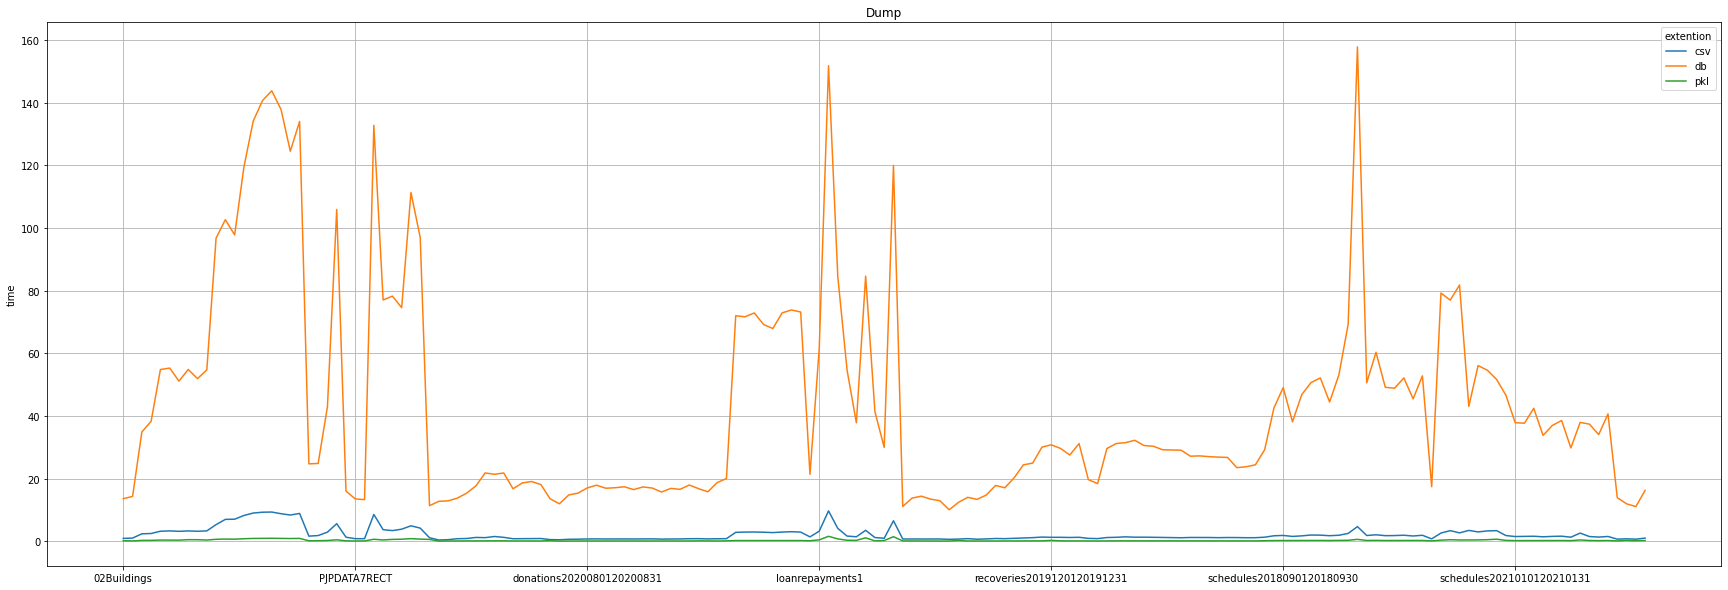

In [6]:
(
	df
	.reset_index()
	.where(lambda x:x.action.eq("dump"))
	.dropna()
	.drop(columns="action")
	.set_index("extention")
	.T
	.plot(
        figsize=(30,10),
        grid=True, 
        title="Dump", 
        ylabel="time"
    )
);

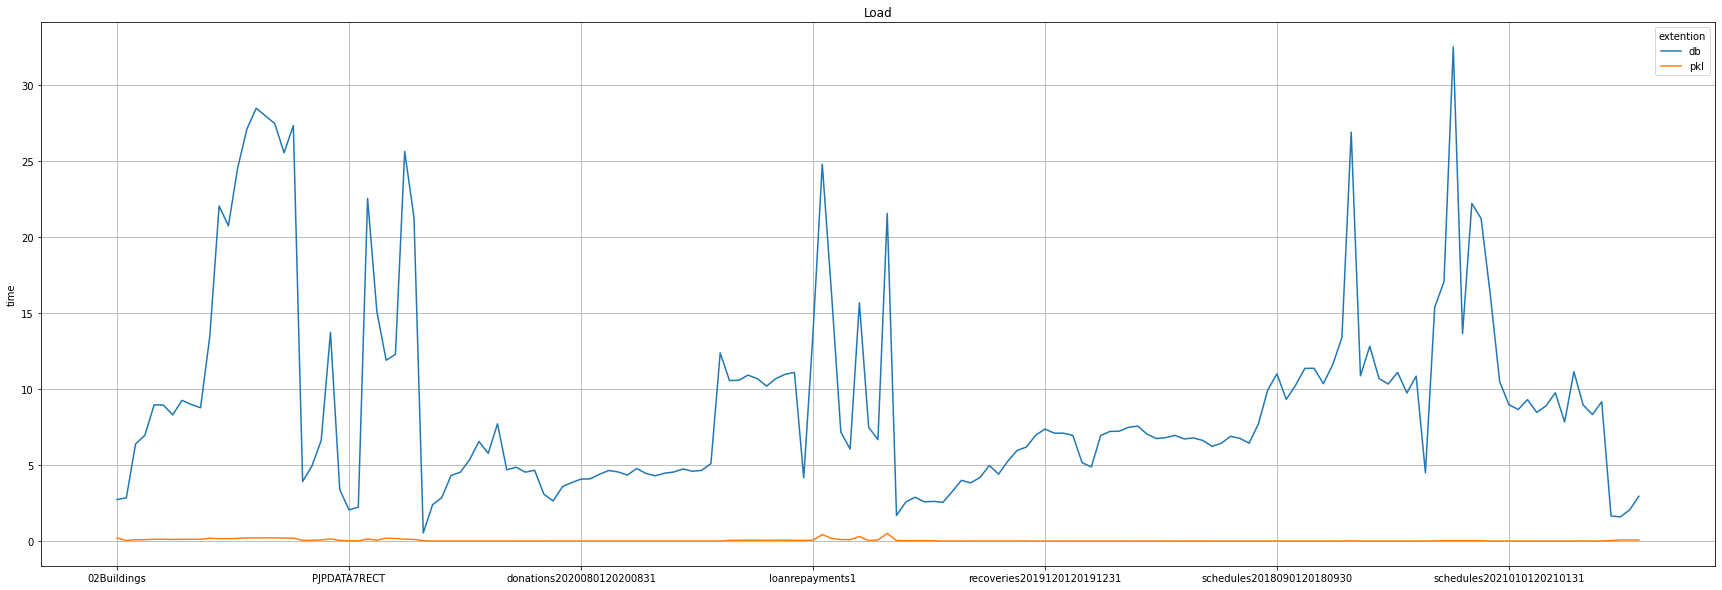

In [13]:
(
	df
	.reset_index()
	.where(lambda x:x.action.eq("load"))
	.dropna()
	.drop(columns="action")
	.set_index("extention")
	.T
	.plot(
        figsize=(30,10),
        grid=True, 
        title="Load", 
        ylabel="time"
    )
);

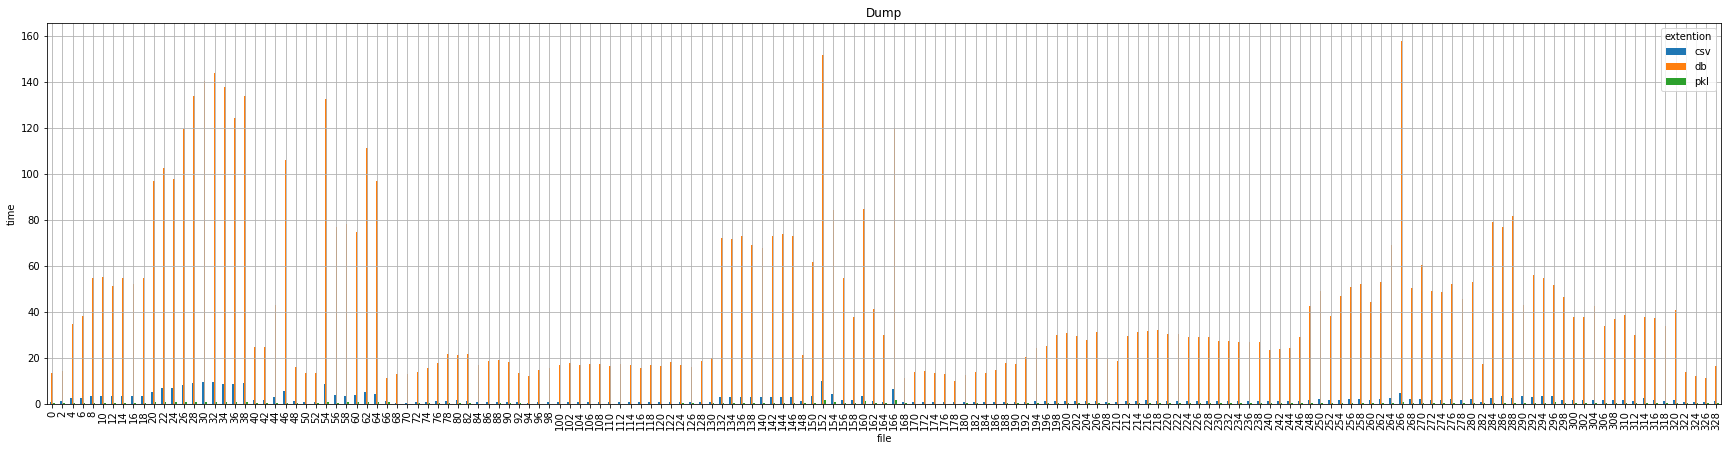

In [14]:
(
	df
	.unstack()
	.T
	.reset_index()
	.where(lambda x:x
	.action
	.eq("dump"))
	.dropna()
	.plot(
        kind="bar",
        figsize=(30,7),
        grid=True,
        title="Dump",
        ylabel="time",
        xlabel="file"
    )
);

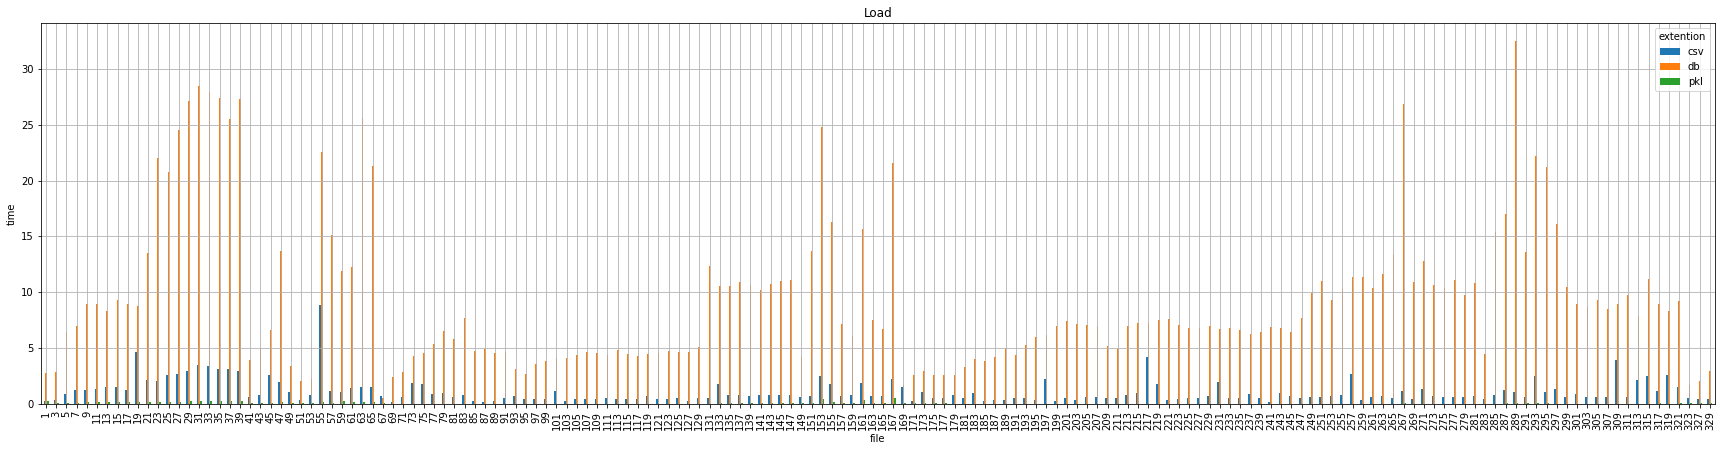

In [15]:
(
	df
	.unstack()
	.T
	.reset_index()
	.where(lambda x:x
	.action
	.eq("load"))
	.dropna()
	.plot(
        kind="bar", 
        figsize=(30,7), 
        grid=True, 
        title="Load",
        ylabel="time",
        xlabel="file"
    )
);

<AxesSubplot:title={'center':'Ratio to DB | LOAD'}, xlabel='data', ylabel='%'>

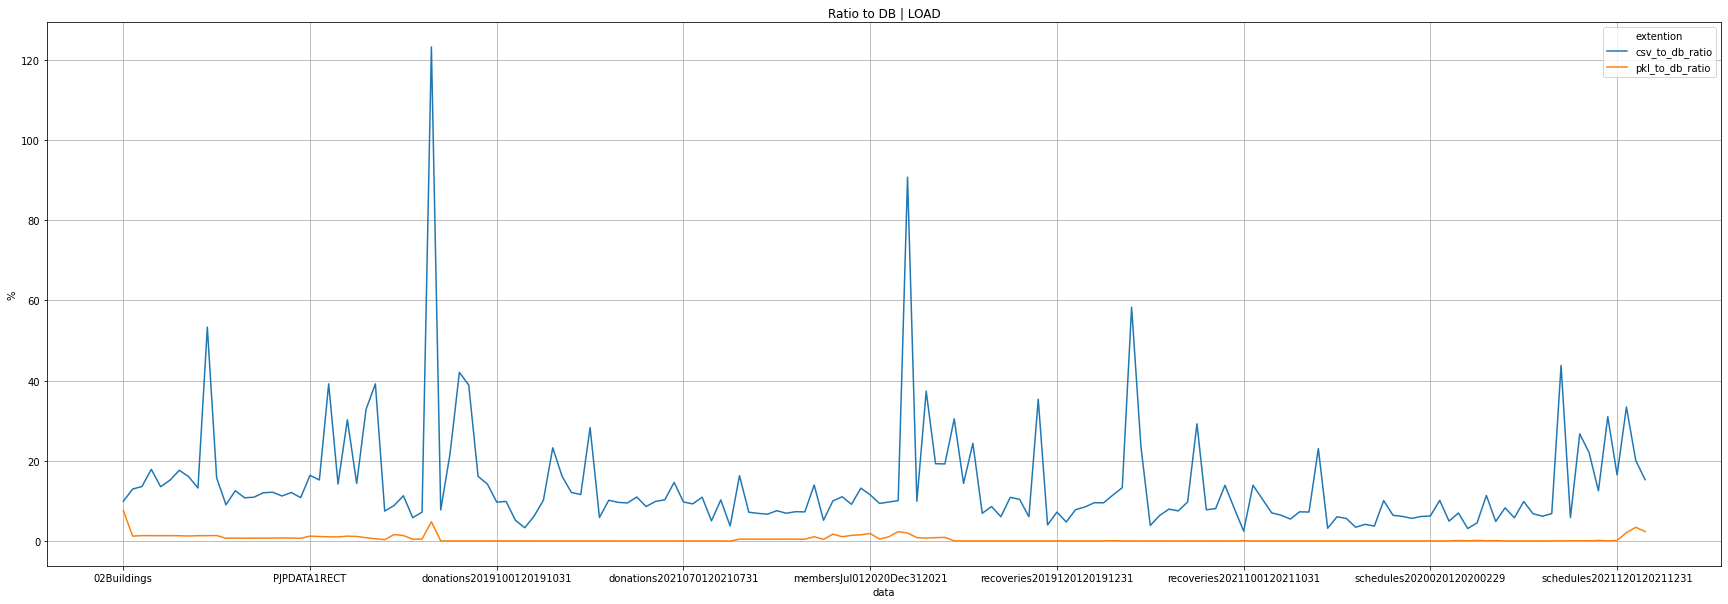

In [16]:
(
	df
	.unstack()
	.T
	.reset_index()
	.where(lambda x:x
	.action
	.eq("load"))
	.dropna()
	.rename(columns={"" : "data"})
	.set_index("data")
	.drop("action", axis=1)
	.assign(
        csv_to_db_ratio = lambda x:round(x.csv/x.db*100,2), 
        pkl_to_db_ratio = lambda x:round(x.pkl/x.db*100,2))
	.loc[:, ['csv_to_db_ratio', 'pkl_to_db_ratio']]
	.plot(figsize=(30,10), grid=True, title="Ratio to DB | LOAD", ylabel="%",)
)

<AxesSubplot:title={'center':'Ratio to DB | DUMP'}, xlabel='data', ylabel='%'>

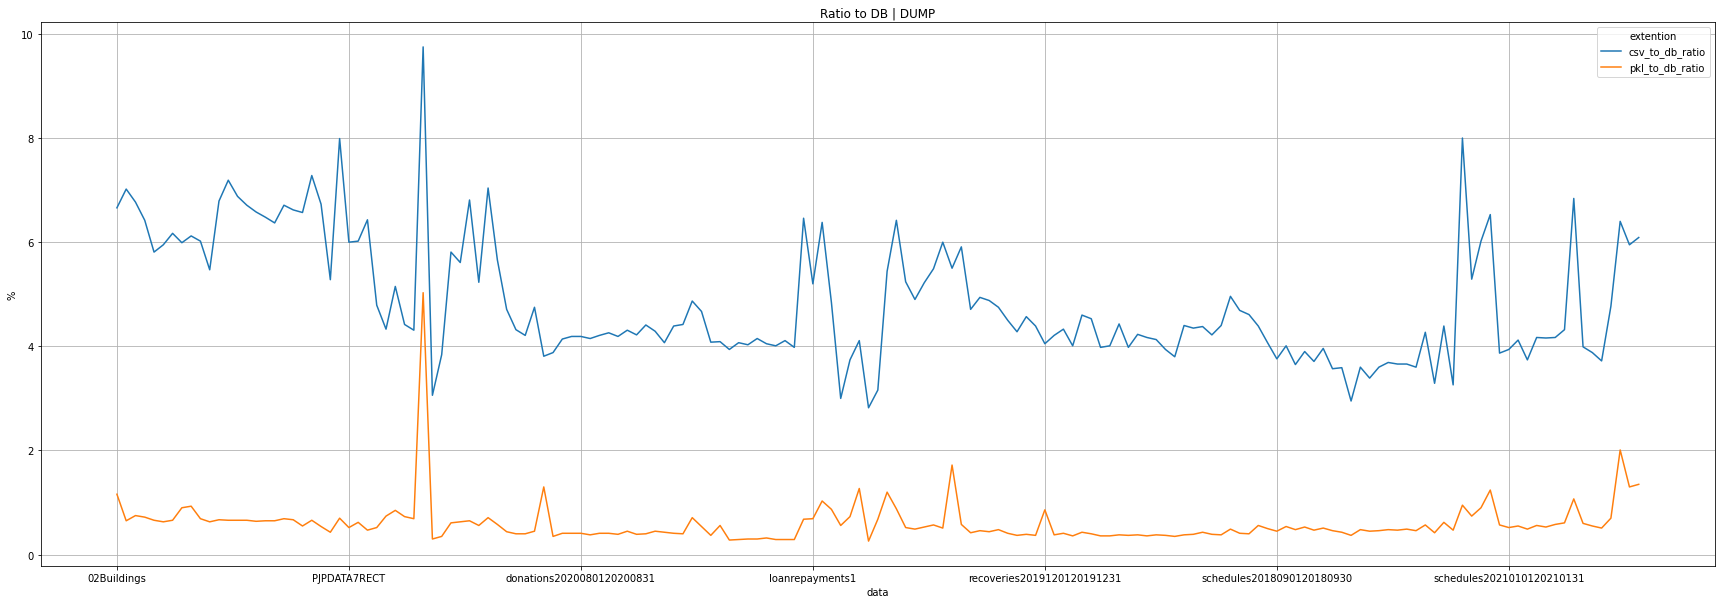

In [17]:
(
	df
	.unstack()
	.T
	.reset_index()
	.where(lambda x:x
	.action
	.eq("dump"))
	.dropna()
	.rename(columns={"" : "data"})
	.set_index("data")
	.drop("action", axis=1)
	.assign(
        csv_to_db_ratio = lambda x:round(x.csv/x.db*100,2), 
        pkl_to_db_ratio = lambda x:round(x.pkl/x.db*100,2))
	.loc[:, ['csv_to_db_ratio', 'pkl_to_db_ratio']]
	.plot(figsize=(30,10), grid=True, title="Ratio to DB | DUMP", ylabel="%")
)